# Modelado de segmentación de clientes de tarjetas de crédito

Notebook enfocado en preprocesamiento avanzado, ingeniería de características y técnicas de clustering para construir segmentos accionables.

## Flujo de trabajo
1. Cargar y normalizar el dataset.
2. Imputar valores faltantes y tratar outliers.
3. Crear variables derivadas útiles para segmentación.
4. Escalar datos, reducir dimensionalidad con PCA y evaluar KMeans.
5. Analizar los clusters resultantes, sus drivers y proponer estrategias.
6. Exportar la tabla final con etiquetas de cluster.

In [1]:
# Importar librerías y cargar el dataset base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import f_oneway

sns.set(style='whitegrid', context='talk')
%matplotlib inline

df = pd.read_csv('CC GENERAL.csv')

nombres_espanol = {
    'CUST_ID': 'ID_CLIENTE',
    'BALANCE': 'SALDO',
    'BALANCE_FREQUENCY': 'FRECUENCIA_SALDO',
    'PURCHASES': 'COMPRAS',
    'ONEOFF_PURCHASES': 'COMPRAS_UNICAS',
    'INSTALLMENTS_PURCHASES': 'COMPRAS_CUOTAS',
    'CASH_ADVANCE': 'ADELANTO_EFECTIVO',
    'PURCHASES_FREQUENCY': 'FRECUENCIA_COMPRAS',
    'ONEOFF_PURCHASES_FREQUENCY': 'FRECUENCIA_COMPRAS_UNICAS',
    'PURCHASES_INSTALLMENTS_FREQUENCY': 'FRECUENCIA_COMPRAS_CUOTAS',
    'CASH_ADVANCE_FREQUENCY': 'FRECUENCIA_ADELANTO_EFECTIVO',
    'CASH_ADVANCE_TRX': 'NUM_TRX_ADELANTO_EFECTIVO',
    'PURCHASES_TRX': 'NUM_TRX_COMPRAS',
    'CREDIT_LIMIT': 'LIMITE_CREDITO',
    'PAYMENTS': 'PAGOS',
    'MINIMUM_PAYMENTS': 'PAGOS_MINIMOS',
    'PRC_FULL_PAYMENT': 'PORC_PAGO_COMPLETO',
    'TENURE': 'ANTIGUEDAD'
}

df.rename(columns=nombres_espanol, inplace=True)

variables_clave = ['SALDO', 'COMPRAS', 'ADELANTO_EFECTIVO', 'LIMITE_CREDITO', 'PAGOS', 'PAGOS_MINIMOS']
print(f'Dataset cargado: {len(df):,} clientes y {len(df.columns)} variables')

Dataset cargado: 8,950 clientes y 18 variables


In [2]:
# Eliminación de identificadores y copia de trabajo
if 'ID_CLIENTE' in df.columns:
    df.drop('ID_CLIENTE', axis=1, inplace=True)

df_model = df.copy()

missing = df_model.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df_model) * 100).round(2)
print('Top columnas con valores faltantes:')
display(pd.DataFrame({'Nulos': missing, '% del total': missing_pct}).head(10))

Top columnas con valores faltantes:


,Nulos,% del total
PAGOS_MINIMOS,313,3.50
LIMITE_CREDITO,1,0.01
SALDO,0,0.00
FRECUENCIA_SALDO,0,0.00
COMPRAS,0,0.00
ADELANTO_EFECTIVO,0,0.00
FRECUENCIA_COMPRAS,0,0.00
COMPRAS_UNICAS,0,0.00
COMPRAS_CUOTAS,0,0.00
FRECUENCIA_COMPRAS_CUOTAS,0,0.00


In [3]:
# Imputación con KNN y tratamiento de outliers
numeric_cols_model = df_model.select_dtypes(include=[np.number]).columns
scaler_imputacion = StandardScaler()
numeric_scaled = scaler_imputacion.fit_transform(df_model[numeric_cols_model])
imputer = KNNImputer(n_neighbors=5)
numeric_imputed_scaled = imputer.fit_transform(numeric_scaled)
numeric_imputed = scaler_imputacion.inverse_transform(numeric_imputed_scaled)
df_model[numeric_cols_model] = numeric_imputed
for col in variables_clave:
    if col in df_model.columns:
        lower = df_model[col].quantile(0.01)
        upper = df_model[col].quantile(0.99)
        df_model[col] = np.clip(df_model[col], lower, upper)
print('✓ Imputación KNN y capping de outliers completados.')
print(f"Total de valores nulos restantes: {df_model.isnull().sum().sum()}")

✓ Imputación KNN y capping de outliers completados.
Total de valores nulos restantes: 0


In [4]:
# Ingeniería de características para el modelado
epsilon = 1e-6
df_model = df_model.assign(
    TASA_UTILIZACION_CREDITO=lambda x: np.clip(x['SALDO'] / (x['LIMITE_CREDITO'].replace(0, np.nan)), 0, 5),
    RATIO_PAGOS_MINIMOS=lambda x: np.clip(x['PAGOS_MINIMOS'] / (x['PAGOS'] + epsilon), 0, 2),
    RATIO_PAGOS_COMPRAS=lambda x: np.clip(x['PAGOS'] / (x['COMPRAS'] + epsilon), 0, 3),
    INTENSIDAD_ADELANTO=lambda x: np.clip(x['ADELANTO_EFECTIVO'] / (x['LIMITE_CREDITO'] + epsilon), 0, 5)
)
feature_summary = df_model[['TASA_UTILIZACION_CREDITO','RATIO_PAGOS_MINIMOS','RATIO_PAGOS_COMPRAS','INTENSIDAD_ADELANTO']].describe().T
display(feature_summary)

,count,mean,std,min,25%,50%,75%,max
TASA_UTILIZACION_CREDITO,8950.0,0.385244,0.351501,0.000007,0.041450,0.301987,0.708236,2.03358
RATIO_PAGOS_MINIMOS,8950.0,0.700704,0.624609,0.001432,0.163404,0.485347,1.087202,2.00000
RATIO_PAGOS_COMPRAS,8950.0,1.840318,1.049014,0.000000,0.919446,1.655043,3.000000,3.00000
INTENSIDAD_ADELANTO,8950.0,0.232473,0.391817,0.000000,0.000000,0.000000,0.351812,5.00000


In [5]:
# Escalado para clustering y reducción de dimensionalidad con PCA
features = df_model.select_dtypes(include=[np.number]).drop(columns=['ANTIGUEDAD'], errors='ignore')
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(features_scaled)
df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
print(f'Componentes PCA retenidos: {pca.n_components_}')
print(f'Varianza total explicada: {pca.explained_variance_ratio_.sum():.2%}')
display(df_pca.head())

Componentes PCA retenidos: 14
Varianza total explicada: 95.92%


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-0.640457,-2.267245,-0.108295,-0.571000,0.076170,-0.410096,-0.023021,-0.465711,0.238309,-0.024204,0.152014,-0.453250,-0.476067,0.168238
1,-2.819446,1.862673,-2.039071,-0.045235,-0.712482,-0.103162,0.561587,0.283143,-0.878944,1.663649,-0.239006,0.121117,0.020943,-0.044095
2,1.322974,0.036066,1.032724,-1.159429,1.240387,2.317750,0.174221,-0.088408,-0.656348,0.094065,-1.123380,-0.394176,0.320372,0.256440
3,-0.231776,-1.029584,0.942862,-1.795895,-0.372139,1.221100,-2.056596,0.101334,1.064692,0.936253,0.618707,-0.043476,0.248496,0.292919
4,-1.285359,-1.430470,0.377843,-0.791770,0.766516,-0.974331,1.331253,-0.442153,0.060708,-0.240828,-0.081846,-0.129077,0.159287,-0.028442


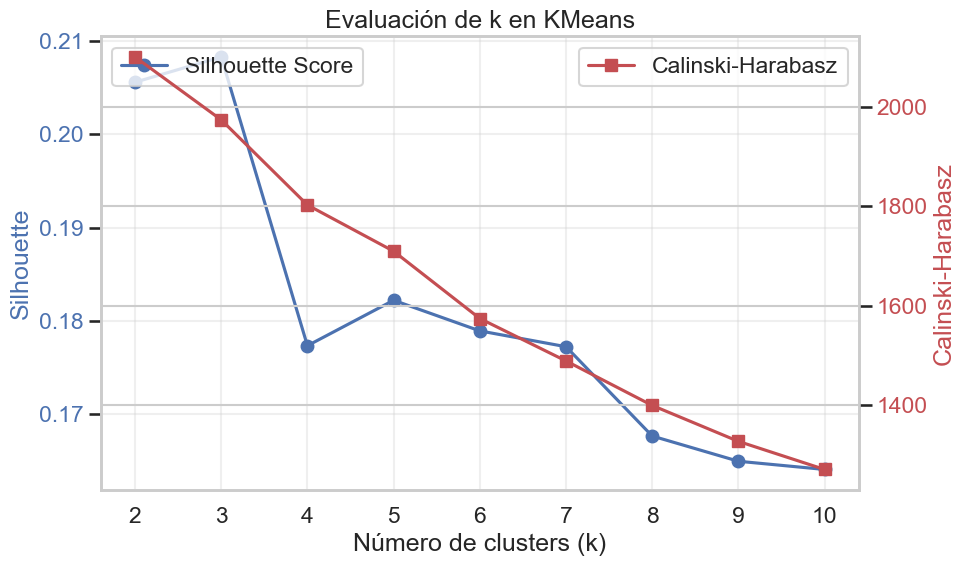

✓ Mejor k según Silhouette: 3
  - Silhouette Score: 0.2083
  - Calinski-Harabasz: 1973.67

Distribución de clientes por cluster:


Cluster
0     970
1    3397
2    4583
Name: count, dtype: int64

In [6]:
# Evaluación de KMeans con distintos valores de k
silhouette_scores = []
ch_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=15)
    labels = kmeans.fit_predict(features_pca)
    silhouette_scores.append(silhouette_score(features_pca, labels))
    ch_scores.append(calinski_harabasz_score(features_pca, labels))
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(k_range, silhouette_scores, 'b-o', label='Silhouette Score')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Silhouette', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(alpha=0.3)
ax2 = ax1.twinx()
ax2.plot(k_range, ch_scores, 'r-s', label='Calinski-Harabasz')
ax2.set_ylabel('Calinski-Harabasz', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Evaluación de k en KMeans')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()
best_k = k_range[np.argmax(silhouette_scores)]
print(f'✓ Mejor k según Silhouette: {best_k}')
print(f"  - Silhouette Score: {max(silhouette_scores):.4f}")
print(f"  - Calinski-Harabasz: {ch_scores[np.argmax(silhouette_scores)]:.2f}")
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=30)
df_model['Cluster'] = kmeans_final.fit_predict(features_pca)
print('\nDistribución de clientes por cluster:')
display(df_model['Cluster'].value_counts().sort_index())

SALDO                                                    \
                mean       median          std        min          max   
Cluster                                                                  
0        2719.865479  1933.131650  2538.978080  12.423203  9338.804814   
1        2605.482153  1836.565272  2150.263471   1.691842  9338.804814   
2         502.569416   144.555083   741.988751   0.065101  5901.592192   

             COMPRAS                                         ...        PAGOS  \
                mean   median          std     min      max  ...         mean   
Cluster                                                      ...                
0        4360.078639  3749.27  2195.235832  900.87  8977.29  ...  4549.255700   
1         233.378790     0.00   447.751755    0.00  4139.56  ...  1788.506055   
2         732.530578   504.96   697.195925    0.00  5080.85  ...   932.572368   

                                                     PAGOS_MINIMOS  \
              median          std  min           max          mean   
Cluster                                                              
0        3572.538910  3401.517165  0.0  13608.715541   1239.936775   
1         976.859575  2303.027302  0.0  13608.715541   1187.178809   
2         607.575208  1102.572187  0.0  13608.715541    315.882854   

                                                          
             median          std        min          max  
Cluster                                                   
0        586.136513  1750.678081  29.259869  8626.691541  
1        673.208585  1519.145285  18.138007  8626.691541  
2        172.959558   495.073131  18.138007  8626.691541  

[3 rows x 30 columns]

C:\Users\andre\AppData\Local\Temp\ipykernel_21824\1536631494.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=var, data=df_model, ax=axes[i], palette='Set2')
C:\Users\andre\AppData\Local\Temp\ipykernel_21824\1536631494.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=var, data=df_model, ax=axes[i], palette='Set2')
C:\Users\andre\AppData\Local\Temp\ipykernel_21824\1536631494.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=var, data=df_model, ax=axes[i], palette='Set2')
C:\Users\andre\AppD

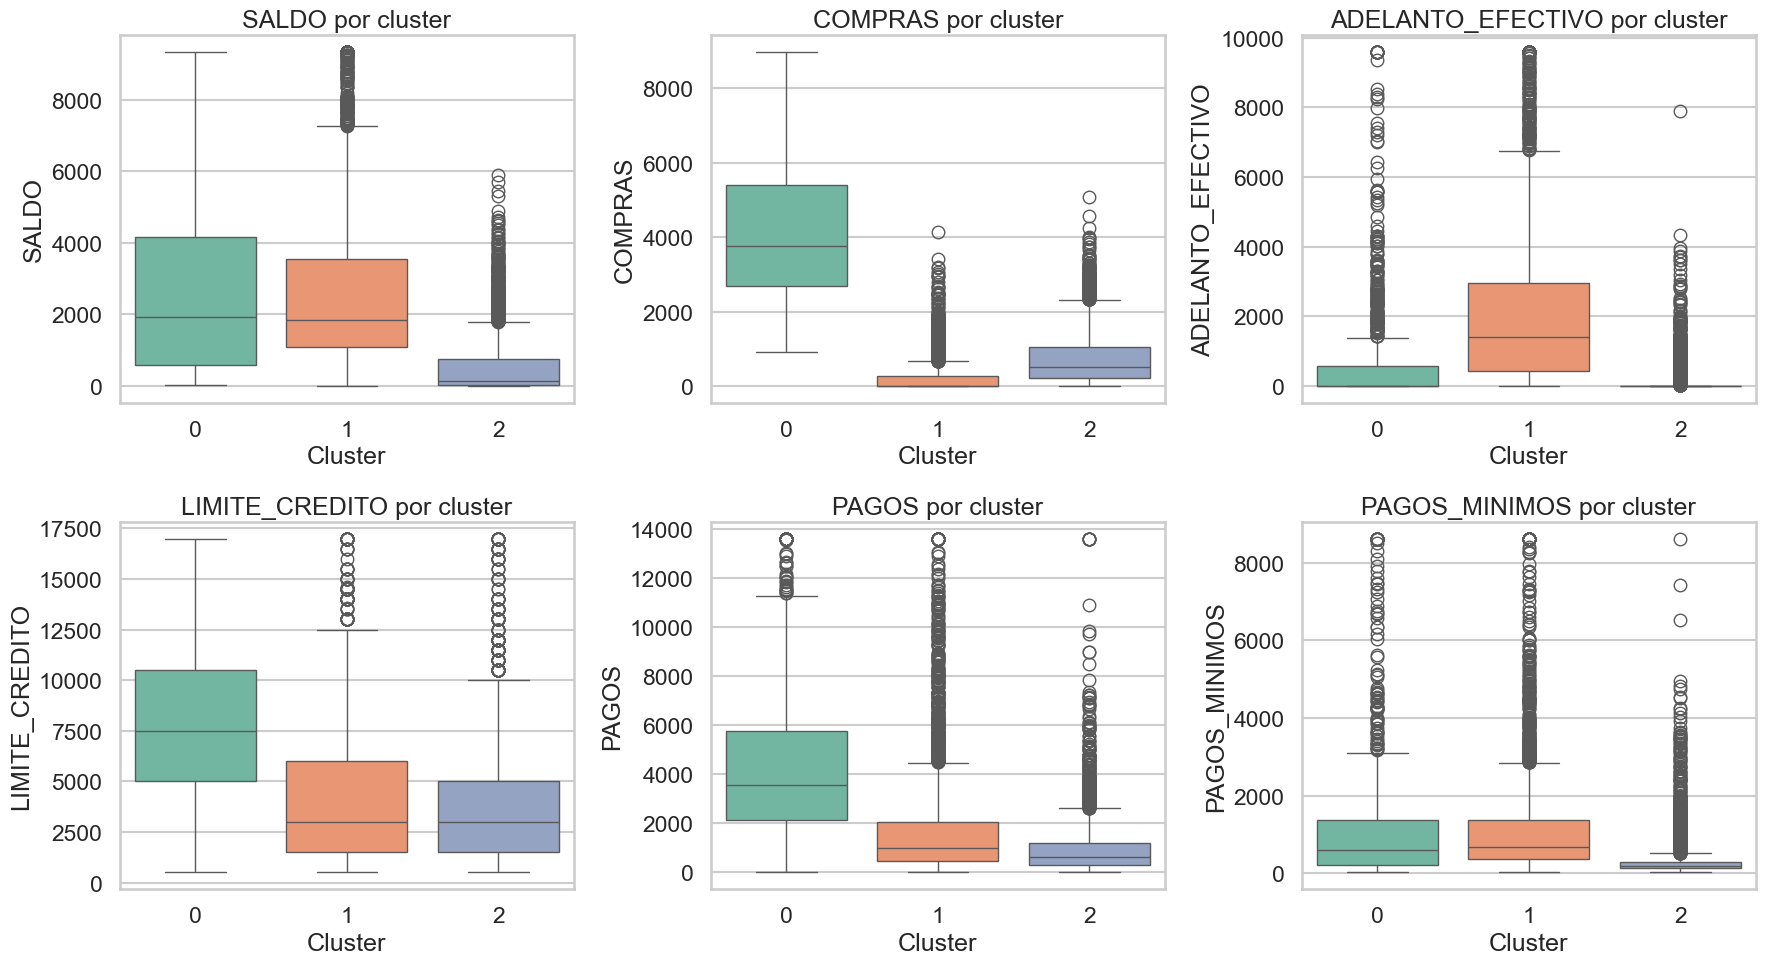

In [7]:
# Resumen estadístico por cluster
cluster_summary = df_model.groupby('Cluster')[variables_clave].agg(['mean','median','std','min','max'])
display(cluster_summary)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, var in enumerate(variables_clave):
    sns.boxplot(x='Cluster', y=var, data=df_model, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{var} por cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(var)
plt.tight_layout()
plt.show()

In [8]:
# Drivers principales: loadings PCA y ANOVA
loadings = pd.DataFrame(pca.components_.T, index=features.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
print('Top contribuciones al PC1:')
display(loadings['PC1'].sort_values(key=np.abs, ascending=False).head(12))
anova_results = {}
for var in variables_clave + ['TASA_UTILIZACION_CREDITO','RATIO_PAGOS_MINIMOS','INTENSIDAD_ADELANTO']:
    if var in df_model.columns:
        grupos = [df_model[df_model['Cluster'] == c][var] for c in sorted(df_model['Cluster'].unique())]
        f_stat, p_val = f_oneway(*grupos)
        anova_results[var] = {'F-stat': f_stat, 'p-value': p_val, 'Significativo': 'Sí' if p_val < 0.05 else 'No'}
anova_df = pd.DataFrame(anova_results).T.sort_values('F-stat', ascending=False)
display(anova_df)

Top contribuciones al PC1:


FRECUENCIA_COMPRAS              0.338259
COMPRAS                         0.319516
NUM_TRX_COMPRAS                 0.302694
RATIO_PAGOS_COMPRAS            -0.291068
FRECUENCIA_COMPRAS_CUOTAS       0.287270
COMPRAS_CUOTAS                  0.256657
FRECUENCIA_ADELANTO_EFECTIVO   -0.250676
FRECUENCIA_COMPRAS_UNICAS       0.249323
INTENSIDAD_ADELANTO            -0.240860
COMPRAS_UNICAS                  0.227448
ADELANTO_EFECTIVO              -0.214075
NUM_TRX_ADELANTO_EFECTIVO      -0.202721
Name: PC1, dtype: float64

,F-stat,p-value,Significativo
COMPRAS,7815.817689,0.0,Sí
TASA_UTILIZACION_CREDITO,2593.615282,0.0,Sí
INTENSIDAD_ADELANTO,2304.910035,0.0,Sí
SALDO,1853.539492,0.0,Sí
ADELANTO_EFECTIVO,1704.227227,0.0,Sí
PAGOS,1359.968293,0.0,Sí
LIMITE_CREDITO,708.12597,0.0,Sí
PAGOS_MINIMOS,654.588588,0.0,Sí
RATIO_PAGOS_MINIMOS,537.81548,0.0,Sí


In [9]:
# Perfil descriptivo de cada cluster
print('='*80)
print('PERFILES DE CLUSTERS')
print('='*80)
for cluster_id in sorted(df_model['Cluster'].unique()):
    cluster_data = df_model[df_model['Cluster'] == cluster_id]
    n_clientes = len(cluster_data)
    pct_total = (n_clientes / len(df_model)) * 100
    print(f'\n📊 CLUSTER {cluster_id} - {n_clientes} clientes ({pct_total:.1f}% del total)')
    print('-'*80)
    print('Variables financieras promedio:')
    for var in variables_clave:
        promedio = cluster_data[var].mean()
        mediana = cluster_data[var].median()
        print(f'  • {var:25s}: Promedio = {promedio:>12,.2f} | Mediana = {mediana:>12,.2f}')
    print('\nIndicadores derivados:')
    print(f"  • TASA_UTILIZACION_CREDITO: {cluster_data['TASA_UTILIZACION_CREDITO'].mean():.2f}")
    print(f"  • RATIO_PAGOS_MINIMOS: {cluster_data['RATIO_PAGOS_MINIMOS'].mean():.2f}")
    print(f"  • INTENSIDAD_ADELANTO: {cluster_data['INTENSIDAD_ADELANTO'].mean():.2f}")
print('\n' + '='*80)

PERFILES DE CLUSTERS

📊 CLUSTER 0 - 970 clientes (10.8% del total)
--------------------------------------------------------------------------------
Variables financieras promedio:
  • SALDO                    : Promedio =     2,719.87 | Mediana =     1,933.13
  • COMPRAS                  : Promedio =     4,360.08 | Mediana =     3,749.27
  • ADELANTO_EFECTIVO        : Promedio =       772.16 | Mediana =         0.00
  • LIMITE_CREDITO           : Promedio =     8,145.41 | Mediana =     7,500.00
  • PAGOS                    : Promedio =     4,549.26 | Mediana =     3,572.54
  • PAGOS_MINIMOS            : Promedio =     1,239.94 | Mediana =       586.14

Indicadores derivados:
  • TASA_UTILIZACION_CREDITO: 0.35
  • RATIO_PAGOS_MINIMOS: 0.39
  • INTENSIDAD_ADELANTO: 0.11

📊 CLUSTER 1 - 3397 clientes (38.0% del total)
--------------------------------------------------------------------------------
Variables financieras promedio:
  • SALDO                    : Promedio =     2,605.48 | Medi

In [10]:
# Estrategias sugeridas por cluster
print('='*80)
print('ESTRATEGIAS DE NEGOCIO RECOMENDADAS')
print('='*80)
for cluster_id in sorted(df_model['Cluster'].unique()):
    cluster_data = df_model[df_model['Cluster'] == cluster_id]
    print(f'\n🎯 Cluster {cluster_id}')
    print('-'*80)
    caracteristicas = []
    compras_promedio = cluster_data['COMPRAS'].mean()
    compras_global = df_model['COMPRAS'].mean()
    if compras_promedio > compras_global * 1.5:
        caracteristicas.append('Compras muy altas')
    elif compras_promedio < compras_global * 0.5:
        caracteristicas.append('Compras bajas')
    adelanto_promedio = cluster_data['ADELANTO_EFECTIVO'].mean()
    adelanto_global = df_model['ADELANTO_EFECTIVO'].mean()
    if adelanto_promedio > adelanto_global * 1.5:
        caracteristicas.append('Uso intensivo de adelantos de efectivo')
    elif adelanto_promedio < adelanto_global * 0.5:
        caracteristicas.append('No usa adelantos')
    pago_completo = cluster_data['PORC_PAGO_COMPLETO'].mean()
    if pago_completo > 0.5:
        caracteristicas.append('Alto cumplimiento de pago total')
    elif pago_completo < 0.1:
        caracteristicas.append('Bajo cumplimiento de pago total')
    print('Características destacadas:')
    for c in caracteristicas:
        print(f'  ✓ {c}')
    print('Estrategias propuestas:')
    if compras_promedio > compras_global * 1.5:
        print('  → Beneficios premium y programas de fidelidad reforzados')
        print('  → Cross-selling de productos con cashback alto')
    if adelanto_promedio > adelanto_global * 1.5:
        print('  → Ofrecer consolidación de deuda y asesoría financiera personalizada')
        print('  → Alertas proactivas sobre costos de adelantos')
    if pago_completo > 0.5:
        print('  → Aumento de límite de crédito y ofertas VIP')
    elif pago_completo < 0.1:
        print('  → Programas de educación financiera y recordatorios automáticos')
        print('  → Planes flexibles de pago para reducir riesgo de mora')
    if compras_promedio < compras_global * 0.5:
        print('  → Campañas de activación y recompensas por primeras compras')
print('\n' + '='*80)

ESTRATEGIAS DE NEGOCIO RECOMENDADAS

🎯 Cluster 0
--------------------------------------------------------------------------------
Características destacadas:
  ✓ Compras muy altas
Estrategias propuestas:
  → Beneficios premium y programas de fidelidad reforzados
  → Cross-selling de productos con cashback alto

🎯 Cluster 1
--------------------------------------------------------------------------------
Características destacadas:
  ✓ Compras bajas
  ✓ Uso intensivo de adelantos de efectivo
  ✓ Bajo cumplimiento de pago total
Estrategias propuestas:
  → Ofrecer consolidación de deuda y asesoría financiera personalizada
  → Alertas proactivas sobre costos de adelantos
  → Programas de educación financiera y recordatorios automáticos
  → Planes flexibles de pago para reducir riesgo de mora
  → Campañas de activación y recompensas por primeras compras

🎯 Cluster 2
--------------------------------------------------------------------------------
Características destacadas:
  ✓ No usa adelant

In [11]:
# Exportar dataset con clusters
output_file = 'CC_GENERAL_clustered.csv'
df_model.to_csv(output_file, index=False)
print(f'✓ Dataset exportado: {output_file}')
print(f'  - Clientes: {len(df_model):,}')
print(f'  - Variables: {len(df_model.columns)}')
print(f'  - Clusters: {df_model["Cluster"].nunique()}')

✓ Dataset exportado: CC_GENERAL_clustered.csv
  - Clientes: 8,950
  - Variables: 22
  - Clusters: 3
